
#EOSC 511
##Assignment OPTIONAL, Lab5b
###Tereza Jarníková
###Student number: 81586142

I) Add foxes to Daisyworld, as specified in Lab 5 question predators:

b) rabbit and fox deathrates d) a rate at which foxes eat rabbits

Note that while we’ve considered Aw and Ab to be non-dimensional daisy concentrations (fractions of the planet covered). They could just as easily be daisies per square km. In the same way a fox “area” of 0.1 could be 0.1 foxes per square km, or 1 fox every 10 square km.

II) Use the steady-state version of your equations to come up with an analytic expression for Aw, Ab, Af and Ar in terms of a (single) death rate chi and birth rates βw = βb, βf and βr. How broad is the range of initial conditions that produce this steady state? What range of death/birth coefficients yield a steady state where one or both of rabbits and foxes are not extinct?

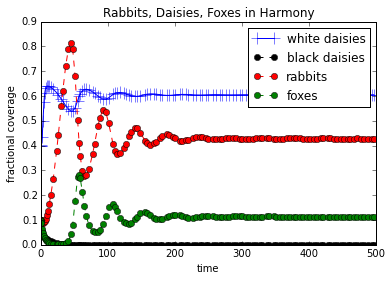

In [1]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


class Integ59(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbits, self.initvars.foxes])
        
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
            
        beta_r = 0.59
        beta_f = .7
        
        user = self.uservars
        
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        chi_duetorabbits = (0.1)*(y[2])
        chi_duetofoxes = (0.5)*(y[3])
        f[0] = y[0] * (beta_w * bare - user.chi-(2)*chi_duetorabbits)
        f[1] = y[1] * (beta_b * bare - user.chi-(2)*chi_duetorabbits)
        f[2] = y[2] * (beta_r * (y[0]+y[1]) - user.rabbit_chi - chi_duetofoxes)
        f[3] = y[3] * (beta_f * y[2] -user.fox_chi)
        
        return f
    

theSolver = Integ59('adapt13.yaml')
timeVals,yVals,errorList=theSolver.timeloop5Err()

yvals=pd.DataFrame.from_records(yVals,columns=['white','black','rabbit','fox'])

thefig,theAx=plt.subplots(1,1)

points,=theAx.plot(timeVals,yvals['white'],'-b+',label='white daisies')
points.set_markersize(12)
theLine1,=theAx.plot(timeVals,yvals['black'],'--ko',label='black daisies')
theLine2,=theAx.plot(timeVals,yvals['rabbit'],'--ro',label='rabbits')
theLine2,=theAx.plot(timeVals,yvals['fox'],'--go',label='foxes')
theAx.set_title('Rabbits, Daisies, Foxes in Harmony')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out=theAx.legend(loc='best')

II) Use the steady-state version of your equations to come up with an analytic expression for Aw, Ab, Af and Ar in terms of a (single) death rate chi and birth rates βw = βb, βf and βr. How broad is the range of initial conditions that produce this steady state? What range of death/birth coefficients yield a steady state where one or both of rabbits and foxes are not extinct?

I did this below, finding answers for D (daisy concentration (see reasoning below)), F (fox conc), and R (rabbit conc). I want D, F, and R to all be positive, which introduces the following constraints:

$$\chi > 0$$

$$\beta_f >0$$

$$\beta_r >0$$

$$\chi^{2}< \beta_r  \beta_d $$

The last is the most constraining.
I plotted this for visualisation below (for a nonzero steady state, chi must be under the blue sheet)


/Users/alena/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


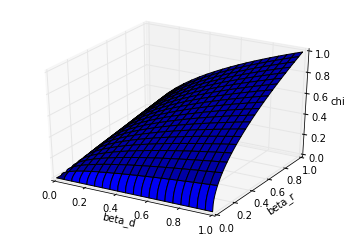

In [4]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random

def fun(x, y):
  return np.sqrt(x*y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, 1.0, 0.005)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('beta_d')
ax.set_ylabel('beta_r')
ax.set_zlabel('chi')

plt.show()

<img src=files/IMG_1477.JPG>
<img src=files/IMG_1476.JPG>